In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import time

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.pytorch import transforms

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

In [3]:
DIR_INPUT = 'Downloads/leaf detection dataset'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

# Loading the device now
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Reading and parsing the CSV

In [4]:
train_df = pd.read_csv(os.path.join(DIR_INPUT, "train.csv"))

In [5]:
train_df

image_id  width  height                  bbox
0     LEAF_0009.jpg   1024    1024  [473, 273, 289, 335]
1     LEAF_0009.jpg   1024    1024  [588, 516, 272, 318]
2     LEAF_0009.jpg   1024    1024  [510, 780, 218, 244]
3     LEAF_0009.jpg   1024    1024  [766, 822, 246, 201]
4     LEAF_0009.jpg   1024    1024    [1, 813, 240, 211]
...             ...    ...     ...                   ...
5341  LEAF_1112.jpg    416     416   [152, 43, 139, 345]
5342  LEAF_1112.jpg    416     416    [320, 80, 79, 261]
5343  LEAF_1113.jpg    416     416   [116, 34, 180, 313]
5344  LEAF_1114.jpg    416     416   [158, 11, 117, 397]
5345  LEAF_1115.jpg    416     416    [96, 84, 295, 225]

[5346 rows x 4 columns]

In [6]:
train_df.ndim

2

In [7]:
train_df.columns

Index(['image_id', 'width', 'height', 'bbox'], dtype='object')

In [8]:
train_df.dtypes

image_id    object
width        int64
height       int64
bbox        object
dtype: object

In [9]:
train_df.describe()

width       height
count  5346.000000  5346.000000
mean    614.458661   614.458661
std     285.117926   285.117926
min     416.000000   416.000000
25%     416.000000   416.000000
50%     416.000000   416.000000
75%    1024.000000  1024.000000
max    1024.000000  1024.000000

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5346 entries, 0 to 5345
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  5346 non-null   object
 1   width     5346 non-null   int64 
 2   height    5346 non-null   int64 
 3   bbox      5346 non-null   object
dtypes: int64(2), object(2)
memory usage: 167.2+ KB


In [11]:
train_df.isnull()

image_id  width  height   bbox
0        False  False   False  False
1        False  False   False  False
2        False  False   False  False
3        False  False   False  False
4        False  False   False  False
...        ...    ...     ...    ...
5341     False  False   False  False
5342     False  False   False  False
5343     False  False   False  False
5344     False  False   False  False
5345     False  False   False  False

[5346 rows x 4 columns]

In [12]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [13]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-4:]
valid_ids = np.append(valid_ids,image_ids[:4])
train_ids = image_ids[4:-4]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

valid_df.shape, train_df.shape

((195, 7), (5151, 7))

In [14]:
valid_df

image_id  width  height      x      y      w      h
0     LEAF_0009.jpg   1024    1024  473.0  273.0  289.0  335.0
1     LEAF_0009.jpg   1024    1024  588.0  516.0  272.0  318.0
2     LEAF_0009.jpg   1024    1024  510.0  780.0  218.0  244.0
3     LEAF_0009.jpg   1024    1024  766.0  822.0  246.0  201.0
4     LEAF_0009.jpg   1024    1024    1.0  813.0  240.0  211.0
...             ...    ...     ...    ...    ...    ...    ...
5341  LEAF_1112.jpg    416     416  152.0   43.0  139.0  345.0
5342  LEAF_1112.jpg    416     416  320.0   80.0   79.0  261.0
5343  LEAF_1113.jpg    416     416  116.0   34.0  180.0  313.0
5344  LEAF_1114.jpg    416     416  158.0   11.0  117.0  397.0
5345  LEAF_1115.jpg    416     416   96.0   84.0  295.0  225.0

[195 rows x 7 columns]

In [15]:
valid_df.columns

Index(['image_id', 'width', 'height', 'x', 'y', 'w', 'h'], dtype='object')

In [16]:
valid_df.ndim

2

In [17]:
valid_df.dtypes

image_id     object
width         int64
height        int64
x           float64
y           float64
w           float64
h           float64
dtype: object

In [18]:
valid_df.describe()

width       height           x           y           w  \
count   195.000000   195.000000  195.000000  195.000000  195.000000   
mean   1005.292308  1005.292308  409.994872  416.558974   68.097436   
std     105.266925   105.266925  259.382425  277.906070   68.033995   
min     416.000000   416.000000    1.000000    1.000000   13.000000   
25%    1024.000000  1024.000000  180.500000  172.000000   29.000000   
50%    1024.000000  1024.000000  391.000000  398.000000   41.000000   
75%    1024.000000  1024.000000  606.000000  645.500000   77.500000   
max    1024.000000  1024.000000  994.000000  995.000000  439.000000   

                h  
count  195.000000  
mean    92.476923  
std     92.451566  
min     16.000000  
25%     40.000000  
50%     59.000000  
75%     89.000000  
max    612.000000

In [19]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 5345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image_id  195 non-null    object 
 1   width     195 non-null    int64  
 2   height    195 non-null    int64  
 3   x         195 non-null    float64
 4   y         195 non-null    float64
 5   w         195 non-null    float64
 6   h         195 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 12.2+ KB


In [20]:
valid_df.isnull()

image_id  width  height      x      y      w      h
0        False  False   False  False  False  False  False
1        False  False   False  False  False  False  False
2        False  False   False  False  False  False  False
3        False  False   False  False  False  False  False
4        False  False   False  False  False  False  False
...        ...    ...     ...    ...    ...    ...    ...
5341     False  False   False  False  False  False  False
5342     False  False   False  False  False  False  False
5343     False  False   False  False  False  False  False
5344     False  False   False  False  False  False  False
5345     False  False   False  False  False  False  False

[195 rows x 7 columns]

In [6]:
class LeafDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms = None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)                
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        image = np.reshape(image,image.shape+(1,))
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {'image': image, 'bboxes': target['boxes'], 'labels': labels}
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [7]:
# This Albumentation for now it is empty.
def transform():
    return A.Compose([ToTensorV2(p = 1.0),], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def collate_fn(batch):
    return tuple(zip(*batch))

In [8]:
train_dataset = LeafDataset(train_df, DIR_TRAIN, transform())
valid_dataset = LeafDataset(valid_df, DIR_TRAIN, transform())


train_data_loader = DataLoader(
    train_dataset,
    batch_size = 16,
    shuffle = False,
    num_workers = 4,
    collate_fn = collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 1,
    shuffle = False,
    num_workers = 4,
    collate_fn = collate_fn
)


In [9]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [10]:
# HELPER FUNCTIONS FOR VIZUALISING / PREDICTING
def get_boxes(tensor,index,score=0.5):

    if index >= len(tensor)  or index<0:
        return 0
    
    temp_boxes = []
    for i in range(len(tensor[index]['boxes'])):
        if tensor[index]['scores'][i] > score:
            temp_boxes.append(tensor[index]['boxes'][i].cpu().detach().numpy().astype(np.int32))    
        
    return temp_boxes    
def get_sample_image(itr):
    images, targets, image_ids = next(it)
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    sample = np.reshape(sample,(sample.shape[1],sample.shape[1]))
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for box in boxes:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), 0, 2)

    ax.set_axis_off()
    ax.imshow(sample,cmap = 'gray')
def get_validation_image(itr):
    images, targets, image_ids = next(itr)
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.eval()

    outputs = model(images)
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
    boxes = get_boxes(outputs,0)

    sample = images[0].permute(1,2,0).cpu().numpy()
    
    boxes = get_boxes(outputs,0)

    sample = images[0].permute(1,2,0).cpu().numpy()
    sample = np.reshape(sample,(sample.shape[1],sample.shape[1]))
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for box in boxes:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), 0, 2)

    ax.set_axis_off()
    ax.imshow(sample, cmap = 'gray')
    
def load_test_dataset():
    data_path = DIR_TEST
    test_dataset = torchvision.datasets.ImageFolder(root = data_path, transform = torchvision.transforms.Compose([
        torchvision.transforms.Grayscale(num_output_channels = 1), torchvision.transforms.ToTensor(),]))
    
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, num_workers = 1, shuffle = False)
    return test_loader

def get_test_image(itr,score = 0.5):
    image, targets = next(itr)
    sample = image
    
    image = image.to(device)
    model.eval()
    outputs = model(image)
    
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]   
    
    boxes = get_boxes(outputs,0,score)
    
    fig, ax = plt.subplots(1, 1, figsize = (16, 8))
    print(sample.shape)
    img = sample[0].permute(1, 2, 0).cpu().numpy()
    print(img.shape)
    
    
    img = np.array(img)
    img = np.reshape(img,(img.shape[1], img.shape[1]))
    print(img.shape)
    for box in boxes:
        x, y, w, h = box
        
        cv2.rectangle(np.float32(img), (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), 0, 2)
    ax.set_axis_off()
    ax.imshow(img,cmap = 'gray')


# Sample of training data augumented


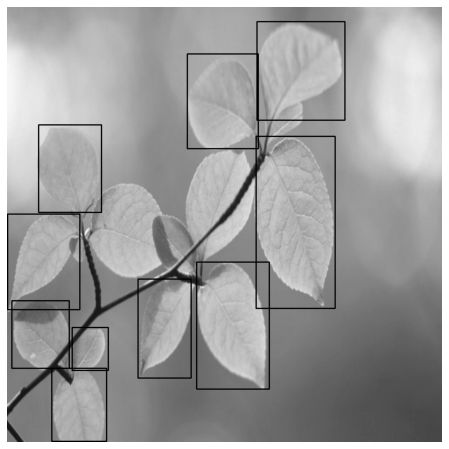

In [11]:
it = iter(train_data_loader)
get_sample_image(it)

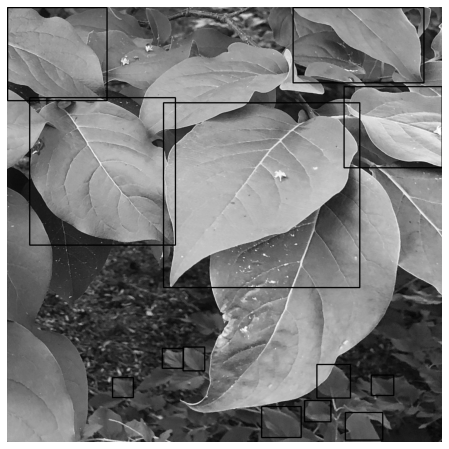

In [12]:
get_sample_image(it)

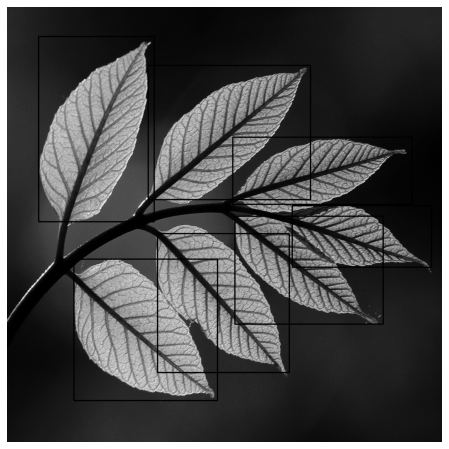

In [13]:
get_sample_image(it)

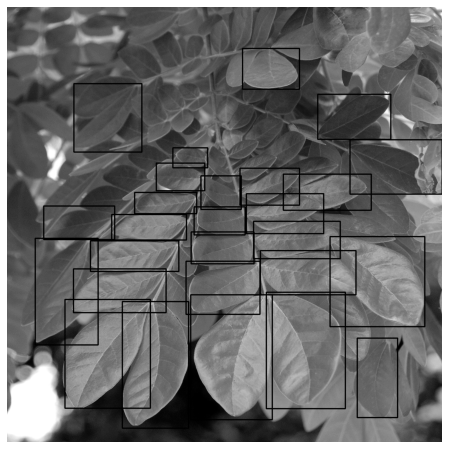

In [14]:
get_sample_image(it)

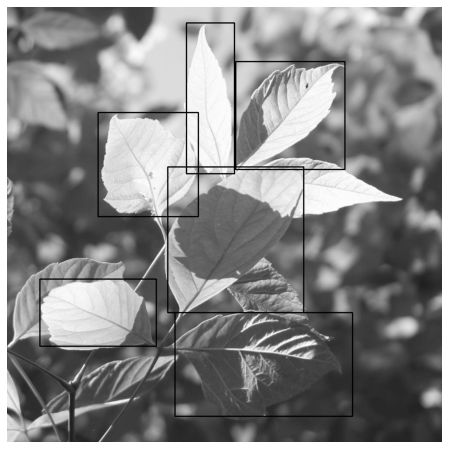

In [15]:
get_sample_image(it)

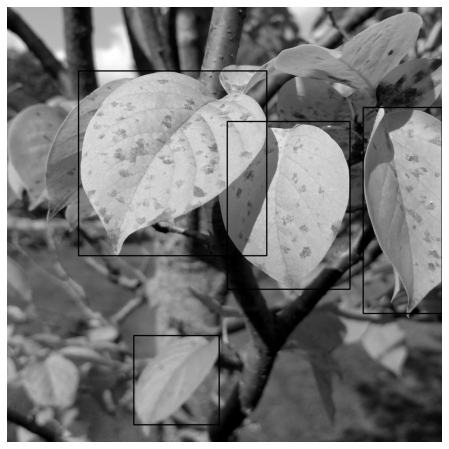

In [16]:
get_sample_image(it)

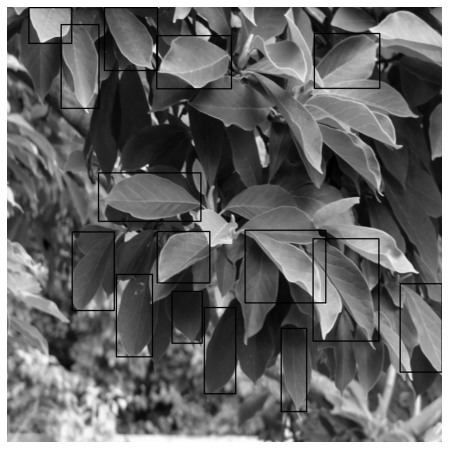

In [17]:
get_sample_image(it)

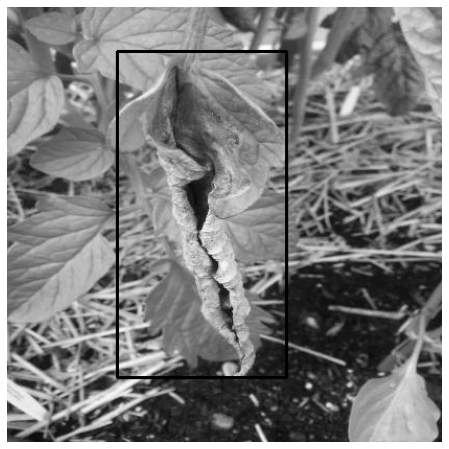

In [18]:
get_sample_image(it)

# Loading ResNet50 trained on COCO

In [19]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [20]:
model.to(device)
print("Model loaded")

Model loaded


# Training

In [21]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)
lr_scheduler = None

num_epochs = 15

In [22]:
loss_hist = Averager()
itr = 1

previous_epoch = 1000
es_rate = 0

es_threshold = 2 # How many epochs without improvement to early stop


for epoch in range(num_epochs):
    loss_hist.reset()
    min_loss = 1000
    
    for images, targets, image_ids in train_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")
        
        itr += 1
                     
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    min_loss = loss_hist.value
    
    if min_loss < previous_epoch:
        previous_epoch = min_loss
        es_rate = 0
        
    else:
        if es_rate < es_threshold:
            es_rate += 1
        elif es_rate >= es_threshold:
            break
    print(f"Epoch #{epoch} loss: {loss_hist.value}")   


Iteration #50 loss: 0.28337323665618896
Epoch #0 loss: 0.41980585802189063
Iteration #100 loss: 0.24948427081108093
Epoch #1 loss: 0.27651798210933176
Iteration #150 loss: 0.4227100908756256
Iteration #200 loss: 0.34724703431129456
Epoch #2 loss: 0.2549254524875695
Iteration #250 loss: 0.2961212992668152
Epoch #3 loss: 0.23299177683575054
Iteration #300 loss: 0.19651088118553162
Iteration #350 loss: 0.073970265686512
Epoch #4 loss: 0.21394161701622144
Iteration #400 loss: 0.1767762303352356
Epoch #5 loss: 0.1988803630458637
Iteration #450 loss: 0.192330002784729
Epoch #6 loss: 0.18387612175773566
Iteration #500 loss: 0.4429085850715637
Iteration #550 loss: 0.1246291846036911
Epoch #7 loss: 0.17210976532857183
Iteration #600 loss: 0.16905084252357483
Epoch #8 loss: 0.162862948496157
Iteration #650 loss: 0.15072302520275116
Iteration #700 loss: 0.17814847826957703
Epoch #9 loss: 0.15656257609666233
Iteration #750 loss: 0.1521284282207489
Epoch #10 loss: 0.16035160123252531
Iteration #800

# Validation (On data from Training)

In [23]:
it = iter(valid_data_loader)

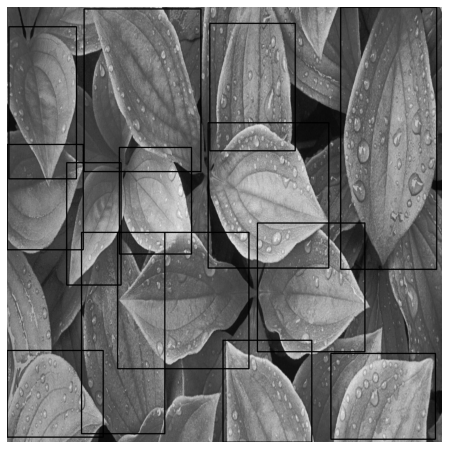

In [24]:
get_validation_image(it)

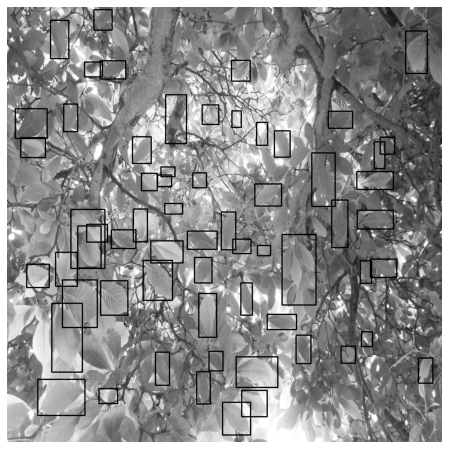

In [25]:
get_validation_image(it)

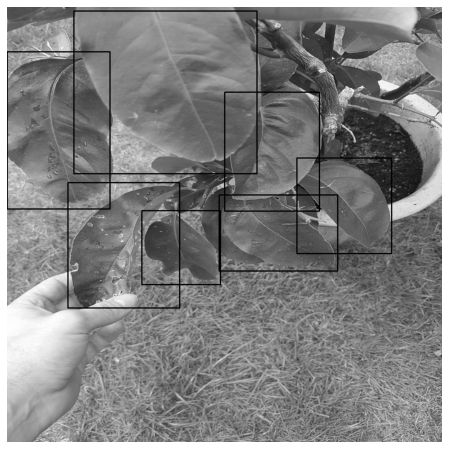

In [26]:
get_validation_image(it)

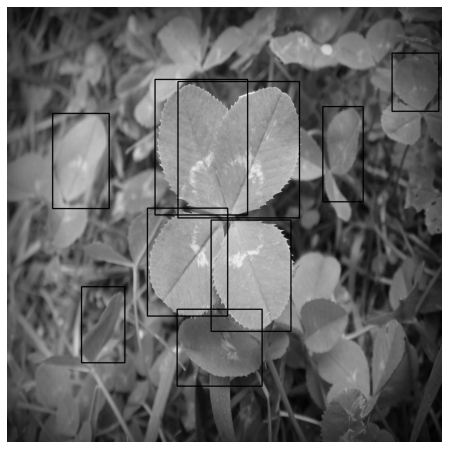

In [27]:
get_validation_image(it)

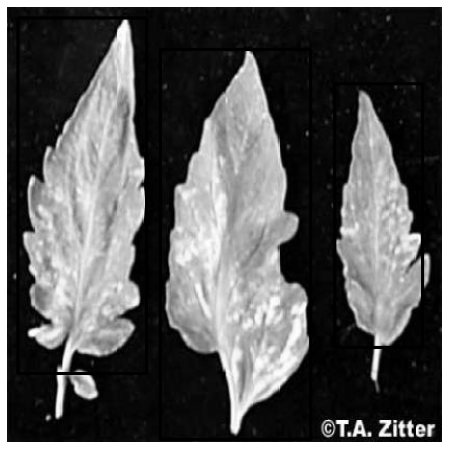

In [28]:
get_validation_image(it)

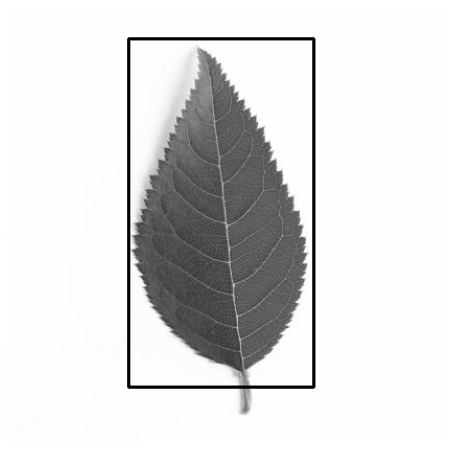

In [29]:
get_validation_image(it)

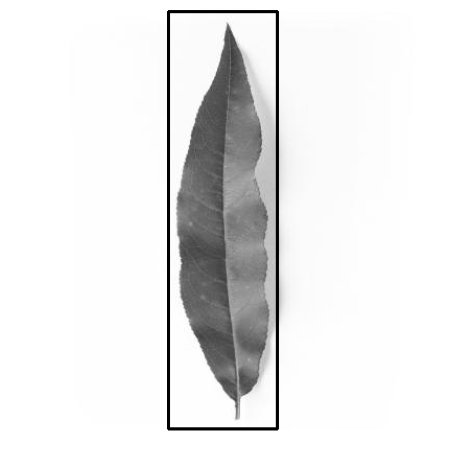

In [30]:
get_validation_image(it)

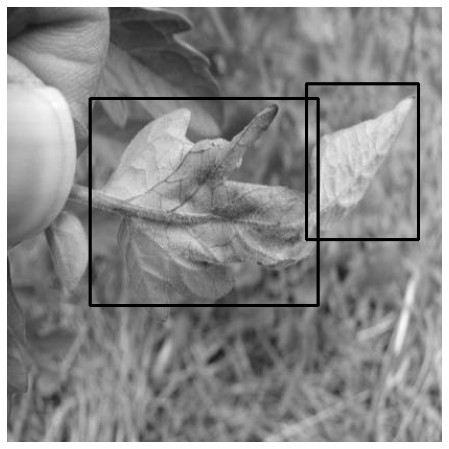

In [31]:
get_validation_image(it)

# Testing

In [32]:
image_list = os.listdir(DIR_TEST + "/leaf")
print(image_list)

['TEST_007.jpg', 'TEST_001.jpg', 'TEST_004.jpg', 'TEST_005.jpg', 'TEST_006.jpg', 'TEST_002.jpg', 'TEST_003.jpg']


In [33]:
it = iter(load_test_dataset())

torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.16729450225830078


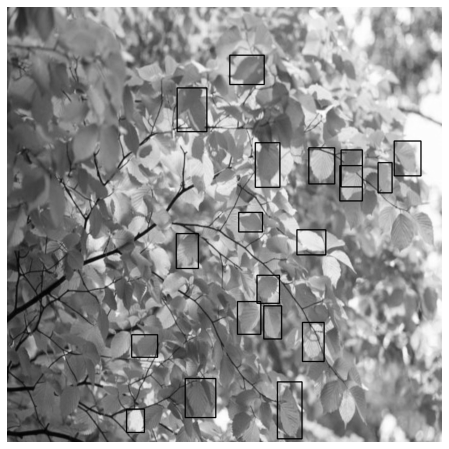

In [34]:
start = time.time()
get_test_image(it, 0.5)
print(time.time() - start)

torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.10052013397216797


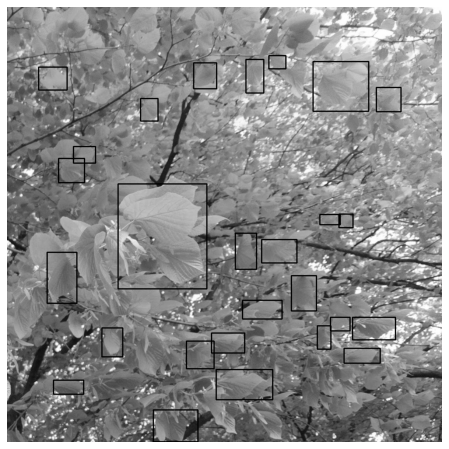

In [35]:
start = time.time()
get_test_image(it, 0.5)
print(time.time() - start)

torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.09701108932495117


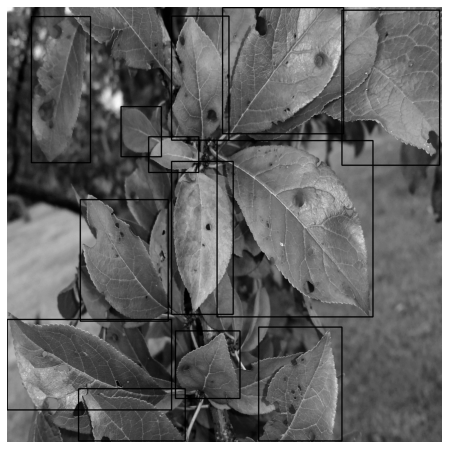

In [36]:
start = time.time()
get_test_image(it, 0.5)
print(time.time() - start)

torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.09490728378295898


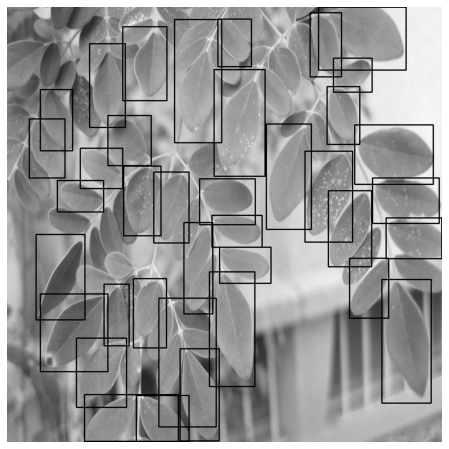

In [37]:
start = time.time()
get_test_image(it, 0.5)
print(time.time() - start)

torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.10325217247009277


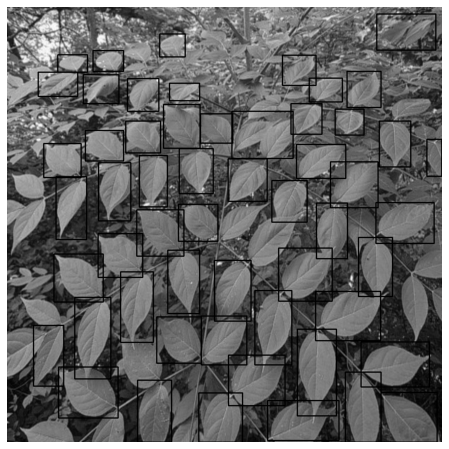

In [38]:
start = time.time()
get_test_image(it, 0.5)
print(time.time() - start)

torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.09249734878540039


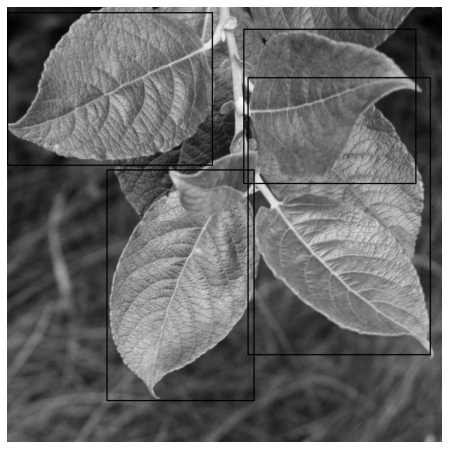

In [39]:
start = time.time()
get_test_image(it, 0.5)
print(time.time() - start)

torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.08995962142944336


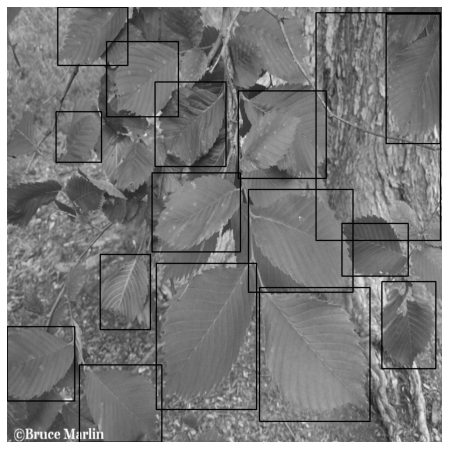

In [40]:
start = time.time()
get_test_image(it, 0.5)
print(time.time() - start)

In [41]:
torch.save(model, 'leaves_fasterrcnn_model.pth')